# Working with the ``Cinnabar`` API

## Passing data to Cinnabar using ``FEMap``

The ``FEMap`` object is the central datastructure in ``cinnabar``. It represents free energy information as a graph:

- **Nodes** are ligands.
- **Edges** are relative free energy differences (ΔΔG) between ligands.
- **Absolute values** (experimental or inferred) can be attached to nodes.

This graph representation is powerful: it allows integration of relative and absolute data, and it provides the foundation for robust statistical analysis and visualization.

In this tutorial, we will walk step-by-step through the construction of an ``FEMap`` and show how it can be used to extract **absolute affinity estimates** using the [maximum likelihood estimation (MLE) approach](https://pubs.acs.org/doi/10.1021/acs.jcim.9b00528). We will then analyse the estimated relative and absolute binding free energies by creating **best-practices plots** that are fully customizable with the ``cinnabar`` API.

### Loading Example RBFE Results

For this example, we will use some RBFE data generated with [OpenFE](https://docs.openfree.energy/en/latest/)
, which is included with ``cinnabar``’s test suite. You can easily swap this out with your own RBFE outputs. 

Our example data is stored in two csv files with a very simple format. The first contains the experimental reference data:

In [1]:
! head ../cinnabar/data/experimental_data.csv

Ligand,expt_DG,expt_dDG
CAT-13a,-8.83,0.10
CAT-13b,-9.11,0.10
CAT-13c,-9.31,0.10
CAT-13d,-10.46,0.10
CAT-13e,-9.95,0.10
CAT-13f,-9.08,0.10
CAT-13g,-9.08,0.10
CAT-13h,-9.62,0.10
CAT-13i,-9.26,0.10


The second contains calculated relative free energy estimates and the associated uncertainties:

In [2]:
! head ../cinnabar/data/computational_data.csv

Ligand1,Ligand2,calc_DDG,calc_dDDG(MBAR),calc_dDDG(additional)
CAT-13b,CAT-17g,0.36,0.11,0.0
CAT-13a,CAT-17g,-0.02,0.1,0.0
CAT-13e,CAT-17g,1.5,0.11,0.0
CAT-4m,CAT-4c,0.78,0.1,0.0
CAT-13k,CAT-4d,-0.59,0.11,0.0
CAT-24,CAT-17e,1.98,0.08,0.0
CAT-13g,CAT-17g,0.86,0.15,0.0
CAT-13d,CAT-13h,1.46,0.1,0.0
CAT-13a,CAT-17i,-0.76,0.11,0.0


We now create an empty ``FEMap`` object and begin adding the relative calculations which define the ``edges`` of the map.

There are two ways to add data:

- ``add_measurement``: accepts a ``Measurement`` object (most general option, supports relative and absolute values).
- ``add_relative_calculation``: a convenience wrapper that automatically builds a relative free energy ``Measurement`` for you.

Here we’ll use the convenience method:

In [3]:
from cinnabar.femap import FEMap

%matplotlib inline
import numpy as np
import pandas as pd
from openff.units import unit

from cinnabar import plotting  # load the matplotlib plotting functionality

femap = FEMap()

# load the computational results
rbfe_results = pd.read_csv("../cinnabar/data/computational_data.csv")

for _, result in rbfe_results.iterrows():
    # add each calculated relative free energy to the FEMap
    femap.add_relative_calculation(
        labelA=result["Ligand1"],  # string identifier for ligandA
        labelB=result["Ligand2"],  # string identifier for ligandB
        value=result["calc_DDG"] * unit.kilocalorie_per_mole,  # the calculated relative free energy with units
        uncertainty=result["calc_dDDG(MBAR)"]
        * unit.kilocalorie_per_mole,  # the uncertainty in the calculated relative free energy with units
        source="OpenFE",  # optional string describing the source of the calculation
    )

<div class="alert alert-block alert-info"> <b>Note:</b> The MLE solver currently expects a single measurement for each relative estimate. If you have repeats (or both forward and backward directions), it is best to combine them before adding to the ``FEMap``. </div>

### Inspecting the FEMap

The ``FEMap`` object exposes some useful properties for sanity checking:

In [4]:
print(femap.n_ligands)  # number of ligands in the graph
print(femap.degree)  # average number of transformations per ligand

36
1.6111111111111112


A key property to consider is whether the graph is fully connected, that is, whether all results are reachable from other results. The ``FEMap`` object provides a method to check this and a visualisation method which can be helpful to identify missing connections in the network.

<div class="alert alert-block alert-info"> <b>Note:</b> The MLE solver currently requires a fully connected graph to estimate absolute binding affinties. </div>

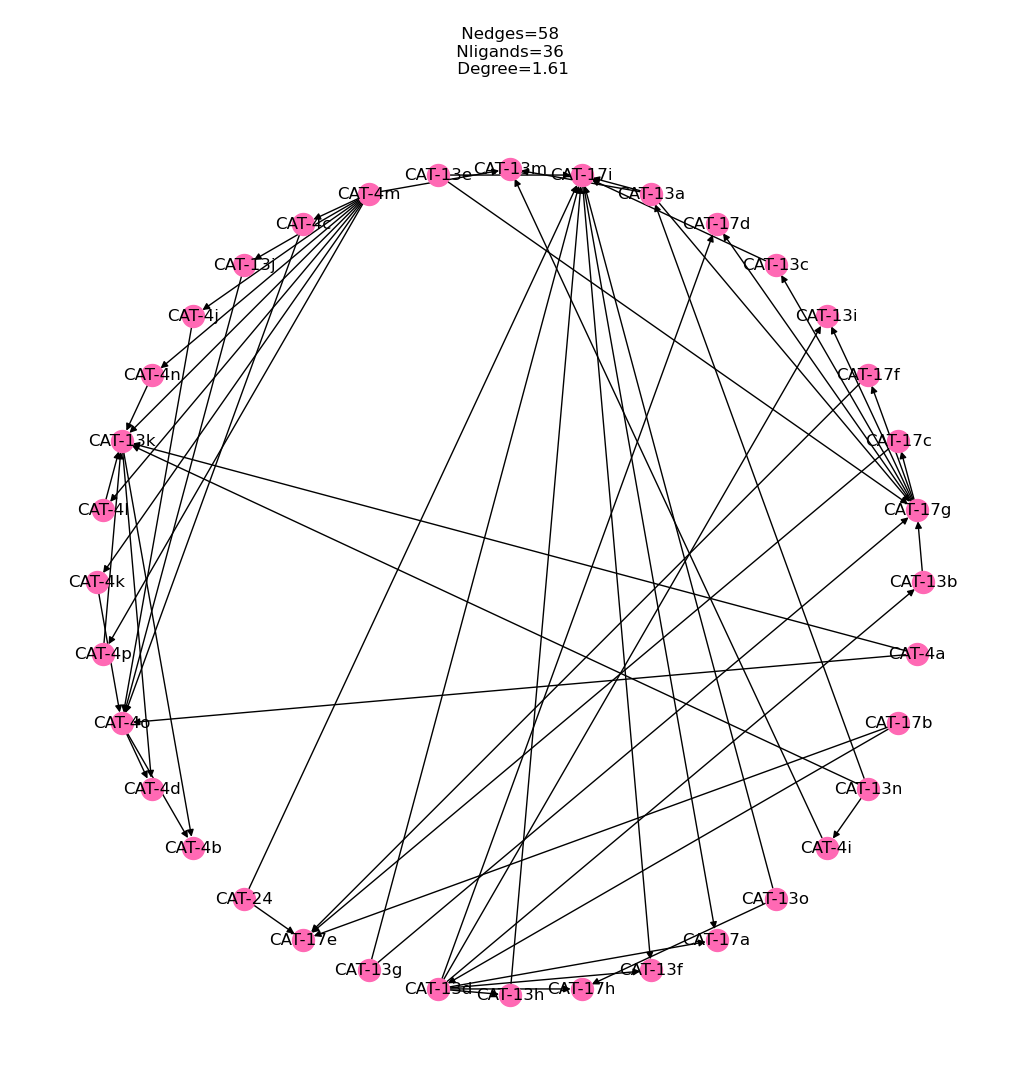

In [5]:
# make sure the graph is fully connected
assert femap.check_weakly_connected()
femap.draw_graph()

## Estimating Absolute Binding Free Energies from Relative Affinities

One of the strengths of ``cinnabar`` is that it provides a simulation-agnostic way to estimate absolute binding affinities from relative binding free energy (RBFE) data.

This capability is essential in two common use cases:

- **Prospective applications**: where the ultimate goal is to rank ligands by predicted potency.
- **Benchmarking exercises**: where we want to assess how well RBFE calculations recover experimental rankings.

Once we have a connected network, we can run the ``MLE`` solver to generate absolute free energies.

This modifies the ``FEMap`` in place:

In [6]:
# this will modify the graph in place adding the MLE estimated values
femap.generate_absolute_values()
absolute_df = femap.get_absolute_dataframe()
absolute_df

,label,DG (kcal/mol),uncertainty (kcal/mol),source,computational
0,CAT-13b,0.378864,0.102983,MLE,True
1,CAT-17g,0.293719,0.069740,MLE,True
2,CAT-17c,-1.540067,0.092647,MLE,True
3,CAT-17f,-1.074339,0.087225,MLE,True
4,CAT-13i,-1.031916,0.108354,MLE,True
5,CAT-13c,0.028110,0.099052,MLE,True
6,CAT-17d,1.377536,0.082133,MLE,True
7,CAT-13a,0.503213,0.066349,MLE,True
8,CAT-17i,-0.027499,0.070761,MLE,True
9,CAT-13m,-0.811262,0.088522,MLE,True


The resulting dataframe records each ligand’s absolute binding free energy estimate, its uncertainty, and metadata such as the ``source`` and whether the value is ``computational``. This ensures clear provenance tracking, especially when mixing experimental and computational absolute measurements in the same ``FEMap``.

We can now rank the ligands by predicted potency:

In [7]:
ranked_df = absolute_df.sort_values(by="DG (kcal/mol)", ascending=True)
ranked_df

,label,DG (kcal/mol),uncertainty (kcal/mol),source,computational
23,CAT-24,-2.992521,0.085422,MLE,True
30,CAT-17a,-1.989695,0.085190,MLE,True
34,CAT-17b,-1.570340,0.092320,MLE,True
2,CAT-17c,-1.540067,0.092647,MLE,True
26,CAT-13d,-1.211377,0.075449,MLE,True
10,CAT-13e,-1.136890,0.099052,MLE,True
28,CAT-17h,-1.122264,0.094168,MLE,True
24,CAT-17e,-1.110508,0.082703,MLE,True
3,CAT-17f,-1.074339,0.087225,MLE,True
4,CAT-13i,-1.031916,0.108354,MLE,True


### Applying an Experimental Shift

The MLE-generated absolute values are always **centered around 0**, which is fine for ranking a single ligand series, however you might find it useful for **visualization or communication** to apply an experimental shift to the predicted values to align the means of the predicted and measured affinities. 

In [8]:
# load the experimental results to compute the mean shift
experimental_results = pd.read_csv("../cinnabar/data/experimental_data.csv")
mean_shift = np.mean(experimental_results["expt_DG"].values)

# subtract the mean of the calculated absolute values
ranked_df["DG (kcal/mol)"] -= ranked_df["DG (kcal/mol)"].mean()
# shift by the experimental mean
ranked_df["DG (kcal/mol)"] += mean_shift
ranked_df

,label,DG (kcal/mol),uncertainty (kcal/mol),source,computational
23,CAT-24,-12.318910,0.085422,MLE,True
30,CAT-17a,-11.316084,0.085190,MLE,True
34,CAT-17b,-10.896729,0.092320,MLE,True
2,CAT-17c,-10.866456,0.092647,MLE,True
26,CAT-13d,-10.537766,0.075449,MLE,True
10,CAT-13e,-10.463279,0.099052,MLE,True
28,CAT-17h,-10.448653,0.094168,MLE,True
24,CAT-17e,-10.436897,0.082703,MLE,True
3,CAT-17f,-10.400727,0.087225,MLE,True
4,CAT-13i,-10.358305,0.108354,MLE,True


## Recap

 - ``cinnabar`` provides a **simulation-agnostic API** for absolute binding affinity estimation from RBFE networks.
- ``FEMap`` is built by adding relative calculations (via ``add_relative_calculation`` or ``add_measurement``).
- The network connectivity can be checked with ``FEMap.check_weakly_connected()``.
- Absolute affinities are generated in place using ``FEMap.generate_absolute_values()`` and retrieved with ``FEMap.get_absolute_dataframe()``.
- Predicted absolute affinities are centered around ``0``, but can be shifted to align with experiment if needed.

That completes the basic tutorial of using the ``cinnabar`` API for absolute affinity estimation. Hopefully, this demonstrates the flexibility of the API and gives you an idea of how this might be incorporated into a free energy pipeline using any relative free energy prediction software.

---

# Plotting Relative and Absolute Free Energy Predictions with ``cinnabar``

``cinnabar`` provides high-level plotting functions (powered by Matplotlib or Plotly) for analyzing and comparing relative and absolute binding free energy calculations. All analysis and visualization defaults follow standardized best practices from the [community guidelines](https://doi.org/10.33011/livecoms.4.1.1497)
, ensuring your results are robust, reproducible, and interpretable.

In this example, we will analyze a set of relative binding free energies computed with [OpenFE](https://docs.openfree.energy/en/latest/), and compare them with experimental affinities, a common task in the benchmarking and validation of a free energy pipeline. 

First lets add the experimental measurements to the femap created above:

In [9]:
for _, exp_row in experimental_results.iterrows():
    femap.add_experimental_measurement(
        label=exp_row["Ligand"],
        value=exp_row["expt_DG"] * unit.kilocalorie_per_mole,
        uncertainty=exp_row["expt_dDG"] * unit.kilocalorie_per_mole,
        source="Experimental",
    )

<div class="alert alert-block alert-info"> 
<b>NOTE</b> Be consistent with ligand names when adding experimental and calculated data, as this is how results are matched during plotting and statistical analysis.
</div>

We can check that all experimental data points were correctly matched to the ligands involved in the calculated relative free energies by checking the number of ligands in the graph, we should still have 36:

In [10]:
print(femap.n_ligands)  # make sure we still have 36 ligands

36


# Plotting Relative Free Energies (ΔΔG)

Relative free energy plots allow direct comparison of calculated and experimental ΔΔG values. These plots follow best practices:

- **Only error statistics (RMSE, MUE)** are shown by default. Correlation measures (R², ρ) are not meaningful here, because the direction of a relative transformation is arbitrary.
- **Uncertainty estimates** are bootstrapped (1000 samples with replacement) to provide 95% confidence intervals.

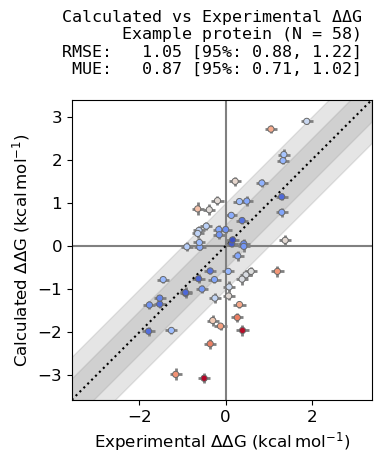

In [11]:
plotting.plot_DDGs(
    femap.to_legacy_graph(), target_name="Example protein", title="Calculated vs Experimental ΔΔG", figsize=5
)

## Symmetry in relative data

Relative transformations are symmetric: ΔΔG(A→B) = –ΔΔG(B→A). This arbitrariness motivates different visualization strategies, without changing the statistics:

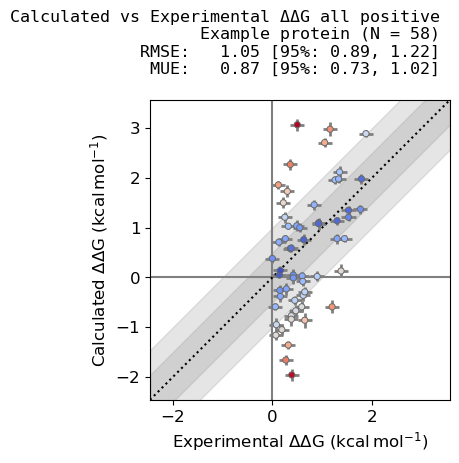

In [12]:
plotting.plot_DDGs(
    femap.to_legacy_graph(),
    target_name="Example protein",
    title="Calculated vs Experimental ΔΔG all positive",
    figsize=5,
    map_positive=True,  # Map all relative free energies to have a positive experimental value
)

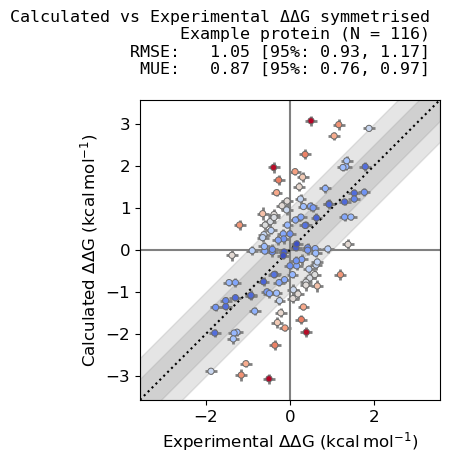

In [13]:
plotting.plot_DDGs(
    femap.to_legacy_graph(),
    target_name="Example protein",
    title="Calculated vs Experimental ΔΔG symmetrised",
    figsize=5,
    symmetrise=True,  # Symmetrise the plot by plotting each point twice
)

## Customizing plots

By default, RMSE and MUE are reported. You can add additional metrics (e.g. relative absolute error, RAE) and choose whether to report the **sample value** (``mle``) or the **bootstrap mean** (``mean``):

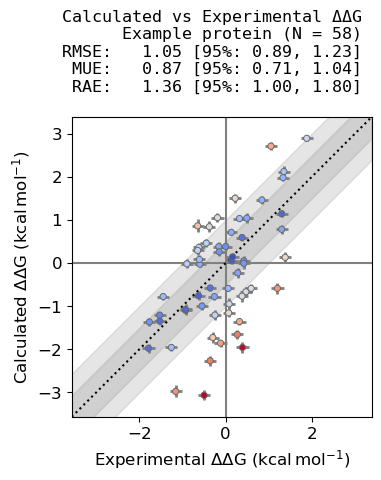

In [14]:
plotting.plot_DDGs(
    femap.to_legacy_graph(),
    target_name="Example protein",
    title="Calculated vs Experimental ΔΔG",
    figsize=5,
    statistics=["RMSE", "MUE", "RAE"],  # add RAE to the plot,
    statistic_type="mean",  # change the reported value from the sample value to the mean of the bootstrapped samples
)

Plots include shaded guidelines (0.5 and 1 kcal/mol) and color points by absolute error. Both are customizable:

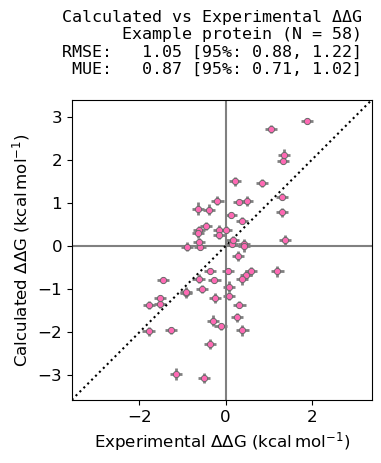

In [15]:
# turn off the guidelines
plotting.plot_DDGs(
    femap.to_legacy_graph(),
    target_name="Example protein",
    title="Calculated vs Experimental ΔΔG",
    figsize=5,
    guidelines=False,  # Turn off the guidelines
    color="hotpink",  # use a custom color
)

For full control, pass Matplotlib settings via scatter_kwargs:

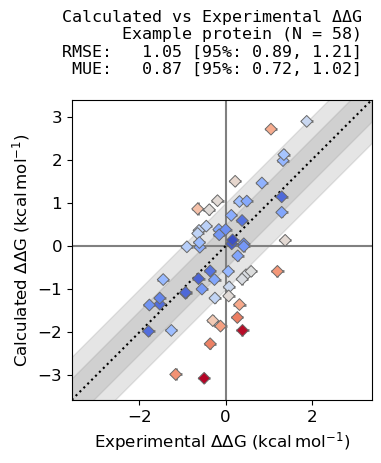

In [16]:
plotting.plot_DDGs(
    femap.to_legacy_graph(),
    target_name="Example protein",
    title="Calculated vs Experimental ΔΔG",
    figsize=5,
    scatter_kwargs={"marker": "D"},
)

If no filename is provided, the plotting function returns a Matplotlib ``Figure`` for further customization.

# Plotting Absolute Free Energies (ΔG)

Absolute free energies can be estimated from a sufficiently connected relative free energy network as shown in the above tutorial. Internally, ``cinnabar`` applies a **maximum likelihood estimator (MLE)** to reconstruct the set of ΔG values most consistent with the relative data. This is performed automatically in plotting functions, or explicitly via ``FEMap.generate_absolute_values()``.

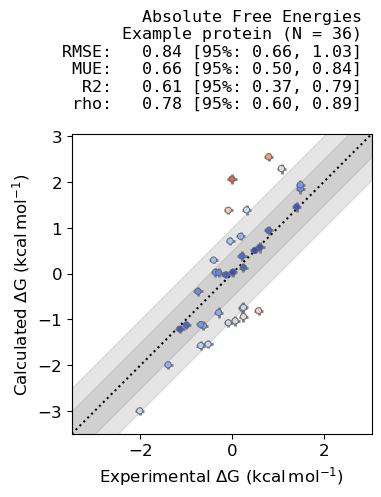

In [17]:
plotting.plot_DGs(
    femap.to_legacy_graph(),
    figsize=5,
    target_name="Example protein",
    title="Absolute Free Energies",
)

Here, both **error and correlation statistics (RMSE, MUE, R², ρ)** are reported, since absolute data are directional and correlation is meaningful.

<div class="alert alert-block alert-warning"> <b>Important:</b> The absolute scale of ΔG values is arbitrary. The MLE reconstruction centers values around zero, so they do not correspond to experimentaly measured absolute binding affinities. Comparisons are valid <i>within a ligand series</i>, but the zero point carries no physical meaning. Thus ΔG estimates from mutlipule systems/series should not be combined for analysis.</div>


## Applying an Experimental Shift

When comparing absolute free energies from different methods, it is sometimes useful to apply a constant shift so that the predicted values align with the experimental mean.

This does not change the relative ranking of ligands or the spread of errors — it only removes the arbitrary offset that arises from the MLE reconstruction of absolute ΔGs. This way, plots are visually centered on the experimental trend, which can help with presentation and comparison.

<div class="alert alert-block alert-warning"> <b>Important:</b> This should be done only for visualization or communication. </div>


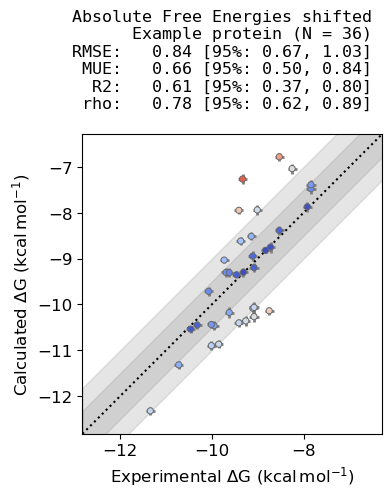

In [18]:
plotting.plot_DGs(
    femap.to_legacy_graph(),
    target_name="Example protein",
    title="Absolute Free Energies shifted",
    figsize=5,
    shift=mean_shift,
)

# Plotting All ΔΔGs (from reconstructed ΔGs)

By default, relative plots show only the ΔΔGs that were **directly simulated** (i.e., edges in your transformation graph). However, once absolute free energies (ΔGs) are reconstructed with the MLE, you can compute **all pairwise ΔΔGs** between ligands.

This has two advantages:

- **Network-independent comparisons**: Different methods may have used different transformation graphs. By reconstructing all ΔΔGs from absolute values, you can compare methods on a common set of relative predictions.
- **Complete benchmarking**: This approach makes it easy to see systematic trends across the full ligand set, not just those pairs chosen for RBFE calculations.

For example, you can generate a plot of all ΔΔGs like this:

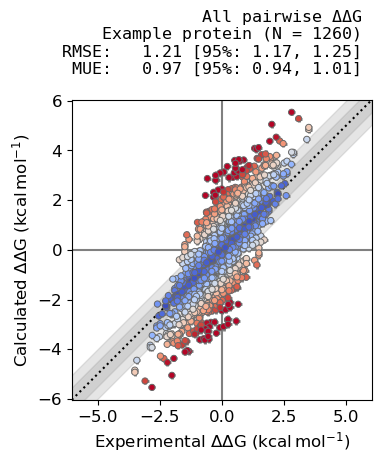

In [19]:
plotting.plot_all_DDGs(femap.to_legacy_graph(), figsize=5, target_name="Example protein", title="All pairwise ΔΔG")

Again, the same best-practices defaults apply (error statistics only, bootstrapped confidence intervals).